**First Try at a Data Analysis Using FastF1**

1. Importing Necessary Libraries and Modules

In [2]:
# Importing all Required Libraries

import fastf1 as ff1
from fastf1 import plotting
from fastf1 import utils
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

2. Creating a Cache for the requeired Information

In [3]:
# Importing the Information into the "cache" folder: 
ff1.Cache.enable_cache('cache') 

3. Getting the Bahrain Event Details (Qualy at First)

In [9]:
# Loading the "Session" Object
quali = ff1.get_session(2022,'Bahrain','Q')
quali.load()


core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v2.2.2]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached data found for session_status_data. Loading data...
api            INFO 	Fetching session status data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for track_status_data. Loading data...
api            INFO 	Fetching tra

4. Getting a List of Driver's Tags and Team Names

In [42]:
Drivers = pd.unique(quali.laps['Driver'])
Teams = pd.unique(quali.laps['Team'])

print(Drivers)
print('\n')
print(Teams)

['LEC' 'VER' 'SAI' 'PER' 'HAM' 'BOT' 'MAG' 'ALO' 'RUS' 'GAS' 'OCO' 'MSC'
 'NOR' 'ALB' 'ZHO' 'TSU' 'HUL' 'RIC' 'STR' 'LAT']


['Ferrari' 'Red Bull Racing' 'Mercedes' 'Alfa Romeo' 'Haas F1 Team'
 'Alpine' 'AlphaTauri' 'McLaren' 'Williams' 'Aston Martin']


5. Selecting the Fastest Lap from each Team

In [55]:
# Empty Dictionary
team_fastest_lap = {}

# Filling the Fastest Lap Dictionary 
for team in Teams: 
    team_fastest_lap[team] = quali.laps[quali.laps.Team == team].pick_fastest()

# Displaying Red Bull's Lap as an Example
team_fastest_lap['Red Bull Racing'].head()


Time            0 days 01:15:15.614000
DriverNumber                         1
LapTime         0 days 00:01:30.681000
LapNumber                           14
Stint                                4
dtype: object

6. Selecting the "Pole" Lap (Fastest Time Overall)

In [56]:
fastest_lap = quali.laps.pick_fastest()
print(fastest_lap.head())

Time            0 days 01:14:47.968000
DriverNumber                        16
LapTime         0 days 00:01:30.558000
LapNumber                           14
Stint                                5
dtype: object


7. Remaking the Team's colors (just Switching Hass from White to black)

In [73]:

Team_Colors_Dict = {}

for team in Teams:

    if team != 'Haas F1 Team':
        Team_Colors_Dict[team] = plotting.team_color(team)
    else: 
        Team_Colors_Dict[team] = '#000000'

Team_Colors_Dict




{'Ferrari': '#dc0000',
 'Red Bull Racing': '#0600ef',
 'Mercedes': '#00d2be',
 'Alfa Romeo': '#900000',
 'Haas F1 Team': '#000000',
 'Alpine': '#0090ff',
 'AlphaTauri': '#2b4562',
 'McLaren': '#ff8700',
 'Williams': '#005aff',
 'Aston Martin': '#006f62'}

7. Comparing theb Team's fastest laps and The fastest lap overall:

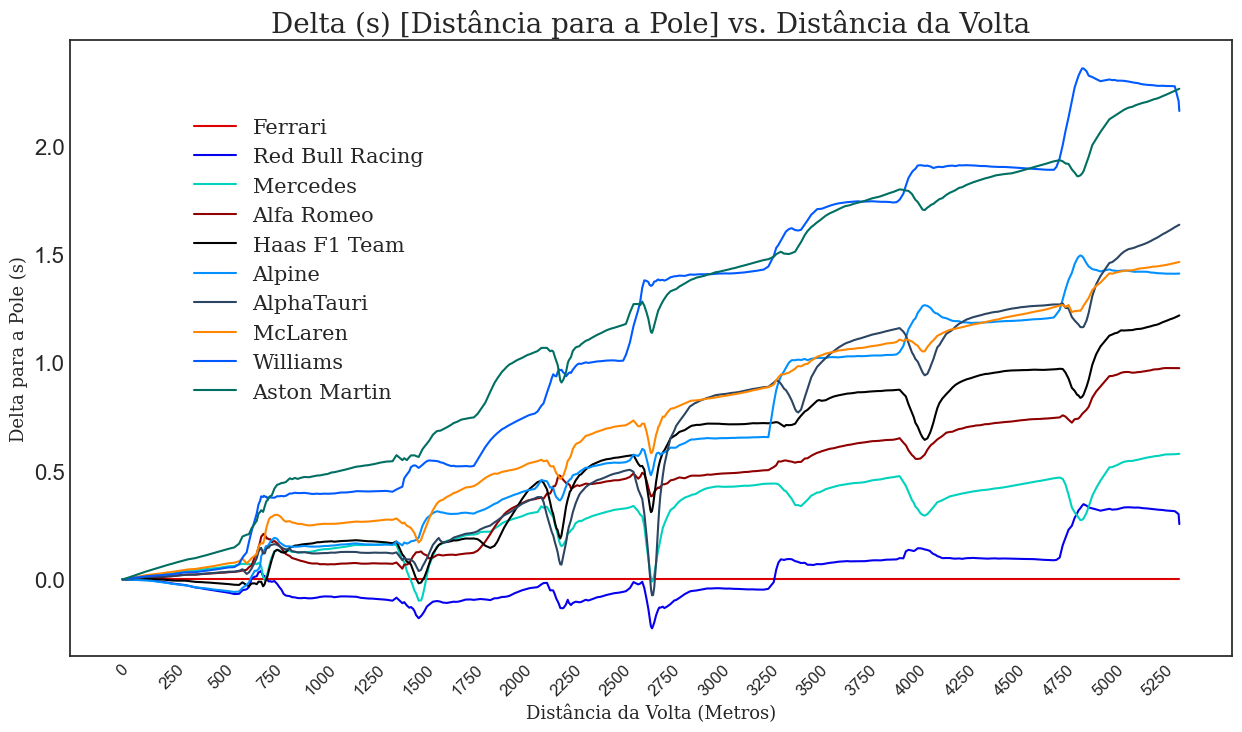

In [396]:
from matplotlib import rcParams
plt.style.use('seaborn-white')
rcParams['figure.figsize'] = (15,8)
ax = plt.axes()

for team in team_fastest_lap:
    delta_time, ref_tel, compare_tel = utils.delta_time(fastest_lap, team_fastest_lap[team])
    plt.plot(ref_tel['Distance'], delta_time, color = Team_Colors_Dict[team], label = team)

plt.ylabel("Delta para a Pole (s)", fontdict={'size': 13, 'family': 'serif'})
plt.xlabel("Distância da Volta (Metros)", fontdict={'size': 13, 'family': 'serif'})
plt.title('Delta (s) [Distância para a Pole] vs. Distância da Volta', fontdict={'size': 20, 'family': 'serif'})
plt.xticks(np.arange(0, np.max(ref_tel['Distance']), step=250), rotation = 45, fontsize = 12)
plt.yticks(fontsize = 16)
plt.legend(loc = (.1,.4), prop = {'size':15, 'family': 'serif'})
plt.show()

8. Plotting The Circuit By Pole Lap

8.1 Defining a Function to make the DataFrame Parsing Easier

In [258]:
def Speed_Data_Frame(Lap_W_Telemetry,Name):
    x = np.array(Lap_W_Telemetry['X'].values)
    y = np.array(Lap_W_Telemetry['Y'].values)
    speed = Lap_W_Telemetry['Speed'].to_numpy().astype(int)
    Rel_Dist = Lap_W_Telemetry['RelativeDistance'].to_numpy()

    return pd.DataFrame(data={'x_' + Name :x,'y_' + Name :y,'Speed_' + Name :speed,'Dist':Rel_Dist}).set_index('Dist')

In [297]:
Telemetria_Ver = team_fastest_lap['Red Bull Racing'].get_telemetry().add_distance()
Telemetria_Pole = fastest_lap.get_telemetry().add_distance()

In [298]:
print(Speed_Data_Frame(Telemetria_Ver,"Vers"))

          x_Vers  y_Vers  Speed_Vers
Dist                                
0.000058    -380    1266         293
0.001110    -378    1325         294
0.001599    -377    1358         294
0.004165    -365    1580         295
0.005880    -360    1702         295
...          ...     ...         ...
0.989097    -400     878         286
0.991369    -394    1004         288
0.994502    -380    1279         290
0.994684    -380    1294         292
0.996507    -377    1419         293

[705 rows x 3 columns]


In [299]:
# Building the Data Frames
Dados_Pole = Speed_Data_Frame(Telemetria_Pole, "Pole")
Dados_Ver = Speed_Data_Frame(Telemetria_Ver, "Ver")

# Concatenating the DataFrames
Dados_Juntos = pd.concat([Dados_Pole,Dados_Ver], axis = 1)

# Interpolating the Data 
Dados_Juntos = Dados_Juntos.sort_index().interpolate().dropna()
print(Dados_Juntos)

          x_Pole       y_Pole  Speed_Pole  x_Ver   y_Ver  Speed_Ver
Dist                                                               
0.000058 -379.00  1303.333333  292.333333 -380.0  1266.0      293.0
0.001110 -378.00  1326.666667  292.666667 -378.0  1325.0      294.0
0.001283 -377.00  1350.000000  293.000000 -377.5  1341.5      294.0
0.001599 -375.00  1381.500000  293.500000 -377.0  1358.0      294.0
0.002319 -373.00  1413.000000  294.000000 -371.0  1469.0      294.5
...          ...          ...         ...    ...     ...        ...
0.994502 -387.25  1140.000000  289.250000 -380.0  1279.0      290.0
0.994684 -385.50  1174.000000  289.500000 -380.0  1294.0      292.0
0.996507 -383.75  1208.000000  289.750000 -377.0  1419.0      293.0
0.997002 -382.00  1242.000000  290.000000 -377.0  1419.0      293.0
0.997692 -380.00  1278.000000  290.000000 -377.0  1419.0      293.0

[1401 rows x 6 columns]


In [300]:
# Where Was Pole Faster ? 
Dados_Juntos['Pole_Faster'] = Dados_Juntos.iloc[:,2] > Dados_Juntos.iloc[:,5]
Dados_Juntos['Time_Rapido'] = np.where(Dados_Juntos['Pole_Faster'] == True, 'Ferrari', 'Red Bull')
print(Dados_Juntos)

          x_Pole       y_Pole  Speed_Pole  x_Ver   y_Ver  Speed_Ver  \
Dist                                                                  
0.000058 -379.00  1303.333333  292.333333 -380.0  1266.0      293.0   
0.001110 -378.00  1326.666667  292.666667 -378.0  1325.0      294.0   
0.001283 -377.00  1350.000000  293.000000 -377.5  1341.5      294.0   
0.001599 -375.00  1381.500000  293.500000 -377.0  1358.0      294.0   
0.002319 -373.00  1413.000000  294.000000 -371.0  1469.0      294.5   
...          ...          ...         ...    ...     ...        ...   
0.994502 -387.25  1140.000000  289.250000 -380.0  1279.0      290.0   
0.994684 -385.50  1174.000000  289.500000 -380.0  1294.0      292.0   
0.996507 -383.75  1208.000000  289.750000 -377.0  1419.0      293.0   
0.997002 -382.00  1242.000000  290.000000 -377.0  1419.0      293.0   
0.997692 -380.00  1278.000000  290.000000 -377.0  1419.0      293.0   

          Pole_Faster Time_Rapido  
Dist                               
0.00

[]

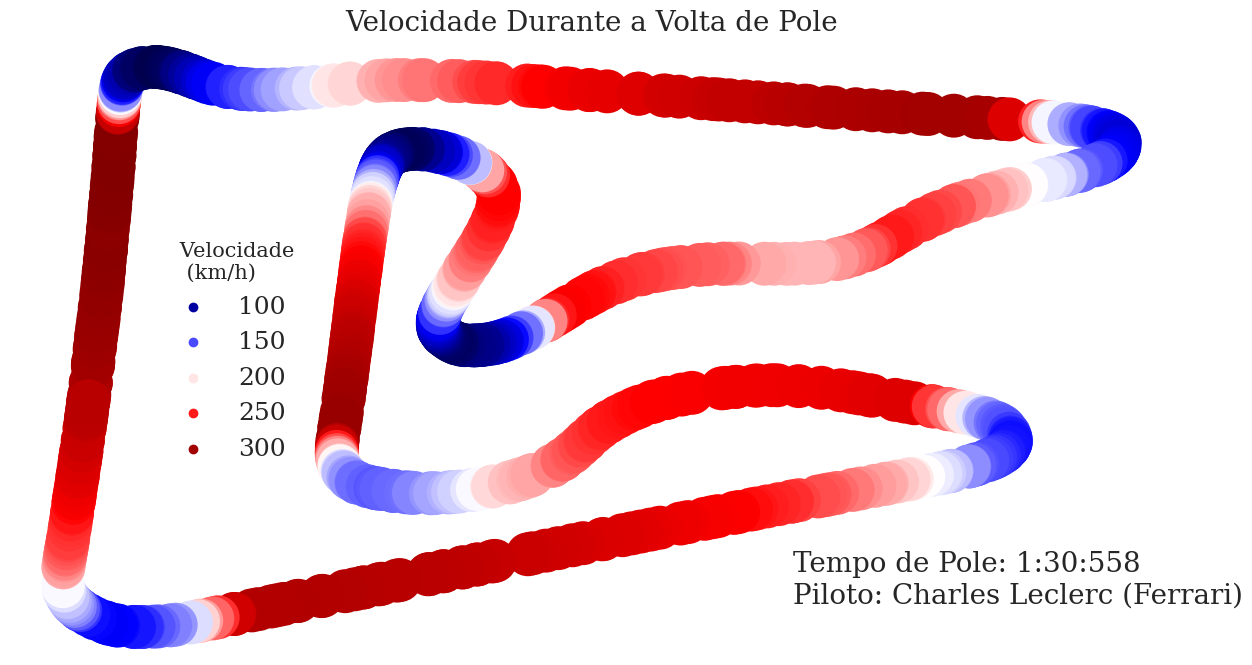

In [397]:
sns.scatterplot(data = Dados_Pole, x = 'x_Pole', y = 'y_Pole', hue = 'Speed_Pole', s = 1000, linewidth = 0, palette='seismic')
plt.axis('off')
plt.legend(loc = (.12,.3), prop = {'size':18, 'family': 'serif'}, title = '   Velocidade\n    (km/h)', frameon = False,
title_fontproperties={'family': 'serif', 'size' : 15})
plt.title('Velocidade Durante a Volta de Pole', fontdict={'size': 20, 'family': 'serif'})
plt.text(5000,-3000,'Tempo de Pole: 1:30:558 \nPiloto: Charles Leclerc (Ferrari)', fontdict={'size':20, 'family': 'serif'})
plt.plot()


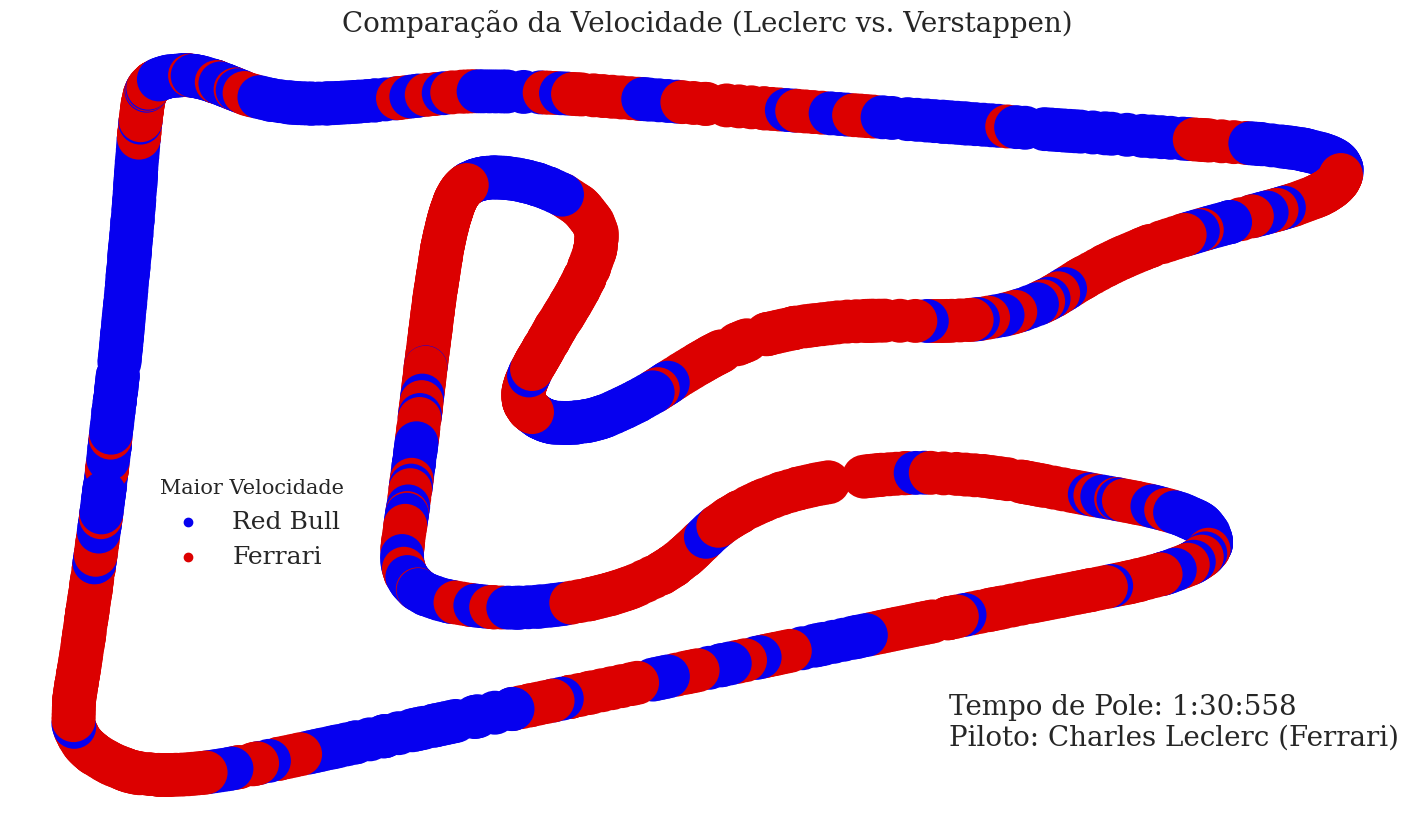

In [401]:

import seaborn as sns
sns.color_palette("rocket")
rcParams['figure.figsize'] = (18,10)
sns.scatterplot(data = Dados_Juntos, x = 'x_Pole', y = 'y_Pole', hue = 'Time_Rapido', s = 1000, linewidth = 0, palette = ['#0600ef','#dc0000'])
plt.axis('off')
plt.title('Comparação da Velocidade (Leclerc vs. Verstappen)', fontdict={'size': 20, 'family': 'serif'})
plt.legend(loc = (.1,.3), prop = {'size':18, 'family': 'serif'}, title = 'Maior Velocidade', frameon = False,
title_fontproperties={'family': 'serif', 'size' : 15})
plt.text(5000,-3000,'Tempo de Pole: 1:30:558 \nPiloto: Charles Leclerc (Ferrari)', fontdict={'size':20, 'family': 'serif'})
plt.show()


0.48148148148148145